# Polarized Propagation
This is a brief how-to on how to use prysm's polarized propagation feature. Users should already be familiar with [Jones Calculus](../tutorials/Jones-Calculus.ipynb), and the [First Diffraction Model](../tutorials/First-Diffraction-Model.ipynb) before going through this how-to. 

When we step outside of the classroom and into the laboratory, we discover that things are not always perfect. In an ideal world, a polarizer is a perfect polarizer, and the degree to which it polarizes doesn't change across the optic. In reality, manufacturing defects can complicate our optical system by introducing unwanted effects. In this how-to, we cover how `prysm` can help you model spatially-varying polarization optics in diffraction problems with polarized field propagation.

We begin with a simple extension of the Jones Matrix $\mathbf{J}$ into the spatial domain:

$$
\mathbf{J}(x,y) =
\begin{pmatrix}
J_{xx}(x,y) & J_{xy}(x,y) \\
J_{yx}(x,y) & J_{yy}(x,y) \\
\end{pmatrix}
$$

All this means is that we consider $\mathbf{J}$ to be a function that varies with position across a given optical element. If you want to model this effect with `prysm`, you would use the following code

In [1]:
from prysm.x.polarization import linear_retarder
import numpy as np

polarizer = (linear_retarder(retardance=np.pi/2,theta=0,shape=[256,256]))
print(polarizer.shape)

(256, 256, 2, 2)


The "`shape`" keyword arg included in every polarizing element in `x.polarization` allows us to define the element as a `shape` $\times$ 2 $\times$ 2 `numpy` array, where the Jones matrix sits in the last two dimensions. In the code block above, `shape` corresponds to our spatial dimensions $x$ and $y$. We can write a simple plotting function to show it off.

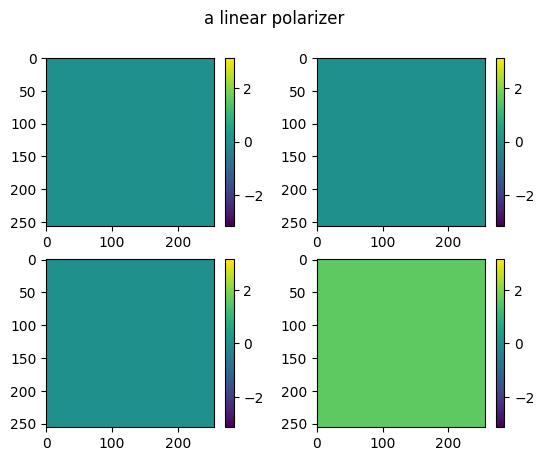

In [2]:
import matplotlib.pyplot as plt

def plot_jones_matrix(J,title='blank title'):
    k = 1

    plt.figure()
    plt.suptitle(title)
    for i in range(2):
        for j in range(2):
            plt.subplot(2,2,k)
            plt.imshow(J[...,i,j],vmin=-np.pi,vmax=np.pi)
            plt.colorbar()
            k += 1
    plt.show()

plot_jones_matrix(np.angle(polarizer),title='a linear polarizer')

This is neat, but doesn't show off how the optic can vary as a function of space. Let's apply a radial error in the diattenuation of the $J_{xx}$ and $J_{yy}$ elements

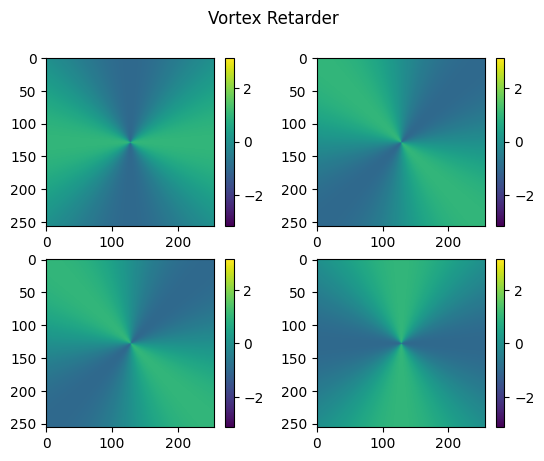

In [4]:
from prysm.coordinates import make_xy_grid,cart_to_polar
from prysm.x.polarization import vector_vortex_retarder

vvr = vector_vortex_retarder(2,256,retardance=np.pi) # a spatially-varying half-wave plate
plot_jones_matrix(np.real(vvr),title='Vortex Retarder')

Now we will put this polarizer in front of a perfect lens with a circular aperture to see how this apodization affects image formation. However, to make `prysm.propagation` compatible with polarized fields we need to call `make_propagation_polarized` from `x.polarization`.

In [5]:
from prysm.x.polarization import make_propagation_polarized
make_propagation_polarized()

This function goes through the supported propagation functions and applies a decorator to them to support propagation of `*shape` $\times$ 2 $\times$ 2 arrays. We can then go and load in a propagation function to examine the PSF

In [6]:
from prysm.propagation import focus_fixed_sampling
from prysm.geometry import circle

def propagate(wf):
    wfout = focus_fixed_sampling(wf,
                                 input_dx=5e3/256,
                                 prop_dist=50e3,
                                 wavelength=1,
                                 output_dx=10e-1,
                                 output_samples=256)
    return wfout

x,y = make_xy_grid(256,diameter=1)
r,t = cart_to_polar(x,y)

# set up a circular aperture and propagate
A = circle(0.5,r)
a_ref = propagate(A)

# now multiply it by the polarizing element
A = A[...,np.newaxis,np.newaxis]
j_out = propagate(vvr*A)

To visualize this in irradiance, we need to compute the Mueller matrix from the Jones matrix `j_out`. We can use `jones_to_mueller` to do this rapidly. The [0,0] element of the resultant Mueller matrix represents the response of the optical system to unpolarized light. Below we compare the focal plane irradiances for imaging with a circular aperture (left) and imaging with a circular aperture with a vortex phase (right). The phase of the vortex is such that the on-axis irradiance completely cancels.

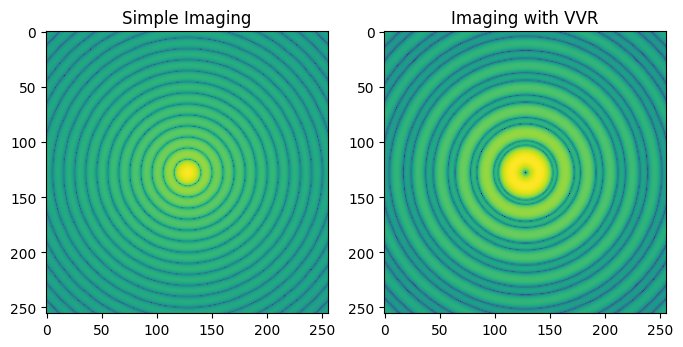

In [8]:
from prysm.x.polarization import jones_to_mueller

m_out  = jones_to_mueller(j_out, broadcast=True)

plt.figure(figsize=[8,4])
plt.subplot(121)
plt.title('Simple Imaging')
plt.imshow(np.log10(np.abs(a_ref)**2))
plt.subplot(122)
plt.title('Imaging with VVR')
plt.imshow(np.log10(m_out[...,0,0]))
plt.show()